In [62]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar


# the following line only works in an IPython notebook
# %matplotlib notebook

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')
# mpl.rc('text', usetex=True)

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

from skimage import feature, filters, measure

In [3]:
frames = pims.ImageSequence('../data/huganir/tp*_results0001.tif', as_grey=True)

In [135]:
tp1 = pims.open('../data/R04_t001.tif')
background1 = tp1[1].clip(-2500, 10000)

tp2 = pims.open('../data/R04_t002.tif')
background2 = tp2[1].clip(-2500, 10000)

tp3 = pims.open('../data/R04_t003.tif')
background3 = tp3[1].clip(-2500, 10000)

tp4 = pims.open('../data/R04_t004.tif')
background4 = tp4[1].clip(-2500, 10000)

In [116]:
# tp2 = np.array(frames[1]).astype(np.uint8)
# tp3 = np.array(frames[2]).astype(np.uint8)

# import imageio
# imageio.imwrite('tp2.png', tp2)
# imageio.imwrite('tp3.png', tp3)

In [144]:
label_im = measure.label(np.array(frames[3]))

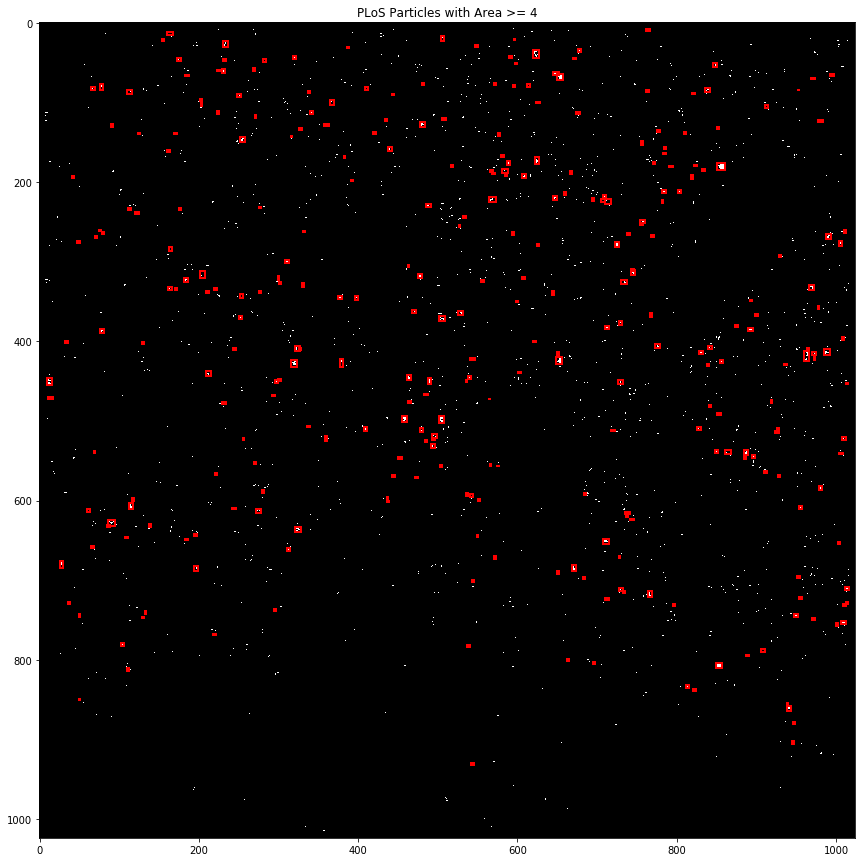

In [145]:
fig, ax = plt.subplots(figsize=(15, 15))
# plt.tight_layout()
ax.set_title('PLoS Particles with Area >= 4')
ax.imshow(frames[3]>0)

for region in measure.regionprops(label_im, frames[3]>0):
    # take regions with large enough areas
    if region.area >= 4:
        # draw rectangle around segmented points
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
fig.savefig("../figures/skimage_size.png", dpi=300)
# plt.close();

In [146]:
fig, ax = plt.subplots(figsize=(15, 15))
# plt.tight_layout()
ax.set_title('PLoS Particles with Mass (Weighted Zeroth Moment) >= 10000')
ax.imshow(frames[3])

for region in measure.regionprops(label_im, frames[3]):
    # take regions with large enough areas
    if region.weighted_moments[0][0] >= 10000:
        # draw rectangle around segmented points
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
plt.legend(handles=[rect])
        
fig.savefig("../figures/skimage_mass_10000.png", dpi=300)
plt.close();

In [147]:
fig, ax = plt.subplots(figsize=(15, 15))
# plt.tight_layout()
ax.set_title('PLoS Particles with Mass (Weighted Zeroth Moment) >= 5000')
ax.imshow(frames[3])

for region in measure.regionprops(label_im, frames[3]):
    # take regions with large enough areas
    if region.weighted_moments[0][0] >= 10000:
#         print(region.weighted_moments[0][0])
        # draw rectangle around segmented points
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
fig.savefig("../figures/skimage_mass_5000.png", dpi=300)
plt.close();

In [148]:
mass = []
for region in measure.regionprops(label_im, frames[3]):
    mass.append(region.weighted_moments[0][0])

plt.title('Frequency vs Weighted Intensity of PLoS Synapses')
plt.ylabel('Frequency')
plt.xlabel(r'Weighted Intensity')
plt.hist(mass, bins=50);
plt.savefig('../figures/freq_vs_mass_synapses.PNG', dpi=300)
plt.close();

In [149]:
size = []
for region in measure.regionprops(label_im, frames[3]):
    size.append(region.area * (0.09*0.09))

plt.title('Frequency vs Size of PLoS Synapses')
plt.ylabel('Frequency')
plt.xlabel(r'Size of detected synapse ($\mu m^2$)')
plt.hist(size, bins=50);
plt.savefig('../figures/freq_vs_size_synapses.PNG', dpi=300)
plt.close();

In [129]:
annotations = pd.read_csv('../data/tp1_substack_labels.csv')
ann_z2 = annotations[annotations['Z']==2];
ann_z2

,Index,Name,Type,X,Y,Width,Height,Color,Fill,LWidth,Pos,C,Z,T
4,4,0002-0110-0251,Oval,246,106,10,9,none,none,0,2,0,2,0
6,6,0002-0070-0280,Oval,275,64,10,12,none,none,0,2,0,2,0
9,9,0002-0023-0277,Oval,272,18,10,10,none,none,0,2,0,2,0
11,11,0002-0112-0292,Oval,287,107,10,10,none,none,0,2,0,2,0
63,63,0002-0071-0198,Oval,194,67,8,8,none,none,0,2,0,2,0
76,76,0002-0045-0257,Oval,254,42,7,7,none,none,0,2,0,2,0
112,112,0002-0163-0283,Oval,280,159,6,8,none,none,0,2,0,2,0
147,147,0002-0009-0198,Oval,194,5,8,9,none,none,0,2,0,2,0
166,166,0002-0051-0332,Oval,328,46,8,10,none,none,0,2,0,2,0
168,168,0002-0002-0325,Oval,322,-2,6,9,none,none,0,2,0,2,0


In [136]:
substack = pims.open('../data/R04_tp1_substack (17-32).tif', as_grey=True)
substack_results = pims.open('../data/substack_results.tiff', as_grey=True)

In [153]:
substack_slice_2 = measure.label(np.array(substack[1]))
substack_results_slice_2 = measure.label(np.array(substack_results[1]))

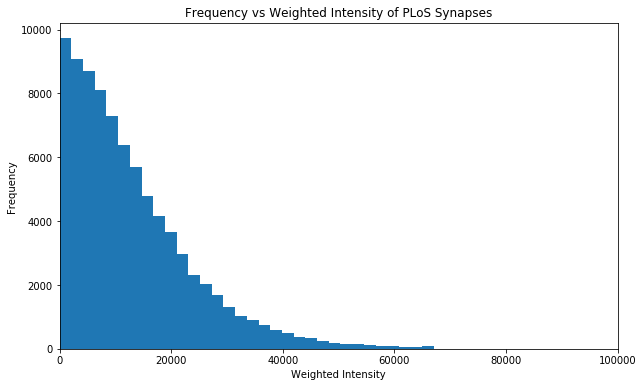

In [154]:
mass = []
for region in measure.regionprops(substack_slice_2, substack[1]):
    mass.append(region.weighted_moments[0][0])
    
plt.title('Frequency vs Weighted Intensity of PLoS Synapses')
plt.ylabel('Frequency')
plt.xlabel(r'Weighted Intensity')
plt.xlim(xmax=100000)
plt.hist(mass, bins=500);
plt.savefig('../figures/freq_vs_mass_synapses.PNG', dpi=300)


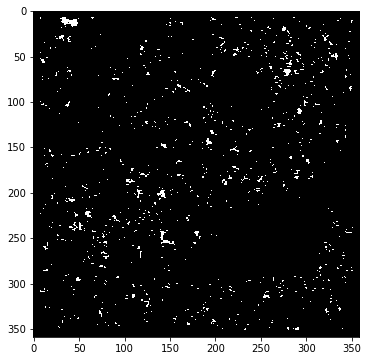

In [156]:
plt.imshow(substack_results[1]>0)

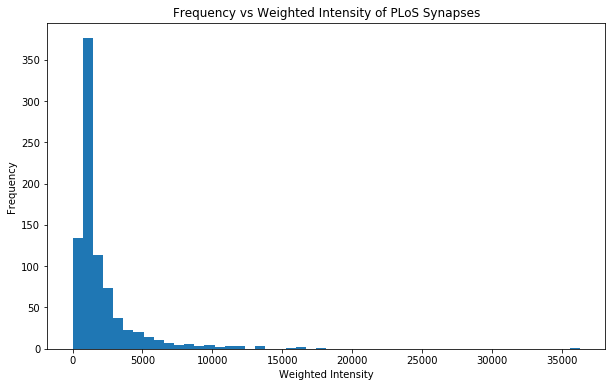

In [157]:
mass = []
for region in measure.regionprops(substack_results_slice_2, substack_results[1]):
    mass.append(region.weighted_moments[0][0])
    
plt.title('Frequency vs Weighted Intensity of PLoS Synapses')
plt.ylabel('Frequency')
plt.xlabel(r'Weighted Intensity')
# plt.xlim(xmax=100000)
plt.hist(mass, bins=50);
plt.savefig('../figures/freq_vs_mass_synapses.PNG', dpi=300)


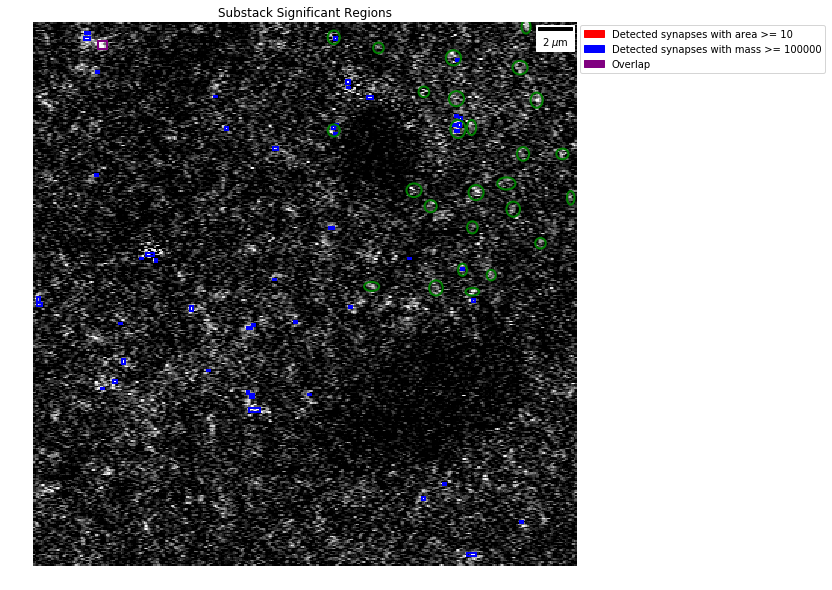

In [161]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Substack Significant Regions')
ax.imshow(substack[1])

for region in measure.regionprops(substack_slice_2, substack[1]):
    if region.area >= 10 and region.weighted_moments[0][0] >= 100000:
        # draw rectangle around segmented points
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='purple', linewidth=2)
        ax.add_patch(rect)
    elif region.weighted_moments[0][0] >= 100000:
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='blue', linewidth=2)
        ax.add_patch(rect)
        
    elif region.area >= 10:
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        
for idx, row in ann_z2.iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    ax.add_patch(elps)
        
red_patch = mpl.patches.Patch(color='red', label='Detected synapses with area >= 10')
blue_patch = mpl.patches.Patch(color='blue', label='Detected synapses with mass >= 100000')
purple_patch = mpl.patches.Patch(color='purple', label='Overlap')
plt.legend(handles=[red_patch, blue_patch, purple_patch], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.3)
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
ax.add_artist(scalebar)
ax.axis('off');

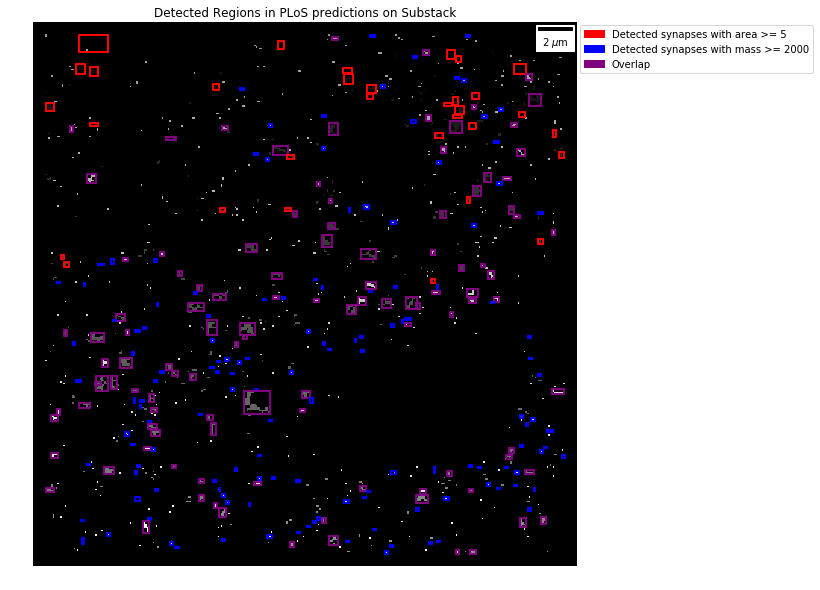

In [162]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Detected Regions in PLoS predictions on Substack')
ax.imshow(substack_results[1])

for region in measure.regionprops(substack_results_slice_2, substack_results[1]):
    if region.area >= 5 and region.weighted_moments[0][0] >= 2000:
        # draw rectangle around segmented points
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='purple', linewidth=2)
        ax.add_patch(rect)
    elif region.weighted_moments[0][0] >= 2000:
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='blue', linewidth=2)
        ax.add_patch(rect)
        
    elif region.area >= 5:
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

red_patch = mpl.patches.Patch(color='red', label='Detected synapses with area >= 5')
blue_patch = mpl.patches.Patch(color='blue', label='Detected synapses with mass >= 2000')
purple_patch = mpl.patches.Patch(color='purple', label='Overlap')
plt.legend(handles=[red_patch, blue_patch, purple_patch], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.3)
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
ax.add_artist(scalebar)
ax.axis('off');

plt.savefig('../figures/substack_detected_regions.PNG', dpi=300)

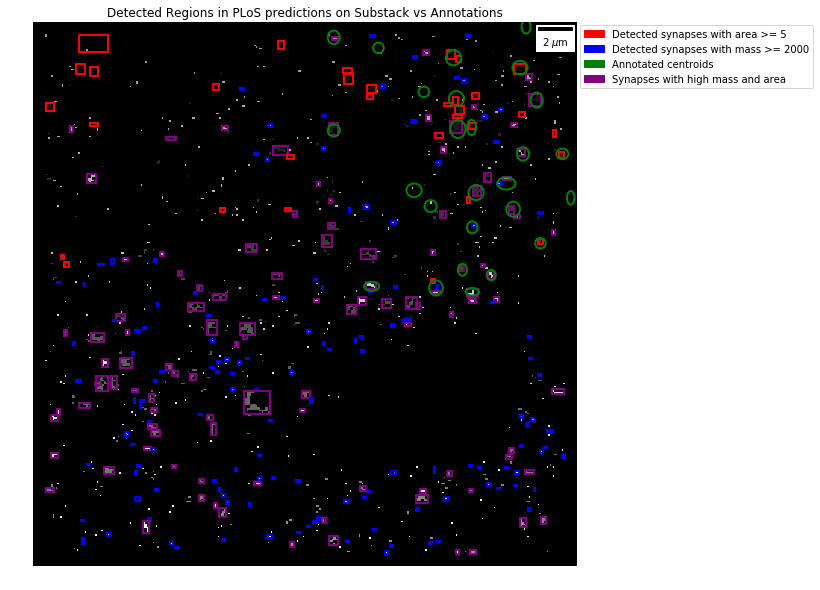

In [191]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Detected Regions in PLoS predictions on Substack vs Annotations')
ax.imshow(substack_results[1])

purple_centers = []
red_centers = []
blue_centers = []

for region in measure.regionprops(substack_results_slice_2, substack_results[1]):
    if region.area >= 5 and region.weighted_moments[0][0] >= 2000:
        # draw rectangle around segmented points
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='purple', linewidth=2)
        ax.add_patch(rect)
        purple_centers.append(region.centroid)

    elif region.weighted_moments[0][0] >= 2000:
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='blue', linewidth=2)
        ax.add_patch(rect)
        blue_centers.append(region.centroid)

        
    elif region.area >= 5:
        minr, minc, maxr, maxc = region.bbox
        rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        red_centers.append(region.centroid)

        
for idx, row in ann_z2.iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    ax.add_patch(elps)

red_patch = mpl.patches.Patch(color='red', label='Detected synapses with area >= 5')
blue_patch = mpl.patches.Patch(color='blue', label='Detected synapses with mass >= 2000')    
annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids')
purple_patch = mpl.patches.Patch(color='purple', label='Synapses with high mass and area')
plt.legend(handles=[red_patch, blue_patch, annotation_patch, purple_patch], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.3)
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
ax.add_artist(scalebar)
ax.axis('off');

plt.savefig('../figures/substack_detected_regions_annotated.PNG', dpi=300)

In [187]:
ann_count = ann_z2.shape[0]
purple_tp = 0
red_tp = 0
blue_tp = 0

for idx, row in ann_z2.iterrows():
    xmin = row['X']
    xmax = row['X'] + row['Width']
    ymin = row['Y']
    ymax = row['Y'] + row['Height']
        
    for center in purple_centers:
        if center[1] <= xmax and center[1] >= xmin:
            if center[0] <= ymax and center[0] >= ymin:
                purple_tp+=1
                
    for center in red_centers:
        if center[1] <= xmax and center[1] >= xmin:
            if center[0] <= ymax and center[0] >= ymin:
                red_tp+=1
                
    for center in blue_centers:
        if center[1] <= xmax and center[1] >= xmin:
            if center[0] <= ymax and center[0] >= ymin:
                blue_tp+=1
                
